In [1]:
%load_ext autoreload
%autoreload 2

import netCDF4 as nc
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Polygon
folder = "C:\\Users\\celian\\OneDrive\\WorldBank\\Cambodia"

import sys
sys.path.insert(0, os.path.join(folder, 'Code', 'lib'))
from gis import *
from functions import *

import rasterio
import fiona
import rasterio.mask

# Explore map

In [2]:
filename = os.path.join(folder, 'Data', 'Raw', 'AgProduction', 'spam2010v1r0_global_value-of-production_vp_crop_a.tif')

print('Load file')
with rasterio.open(filename) as src:
    print("  - nb of band:", src.count)
    print("  - type of band:", {i: dtype for i, dtype in zip(src.indexes, src.dtypes)})
    print("  - band size:", src.height, src.width)
    print("  - crs:", src.crs)
    print("  - affine transformation:", src.affine)
    print("  - bounding box:", src.bounds)
    band = src.read(1)

print('')
print("Focus on Cambodia")
long_lim = (102.294, 107.402)
lats_lim = (14.653, 9.779)
print(~src.affine * (min(long_lim),min(lats_lim)))
print(~src.affine * (max(long_lim),max(lats_lim)))

Load file
  - nb of band: 1
  - type of band: {1: 'float32'}
  - band size: 2160 4320
  - crs: CRS({'init': 'epsg:4326'})
  - affine transformation: | 0.08, 0.00,-180.00|
| 0.00,-0.08, 90.00|
| 0.00, 0.00, 1.00|
  - bounding box: BoundingBox(left=-180.0, bottom=-89.99928, right=179.99856, top=90.0)

Focus on Cambodia
(3387.5415501662, 962.6558506234023)
(3448.8377953511813, 904.1676166704666)


Map of the region


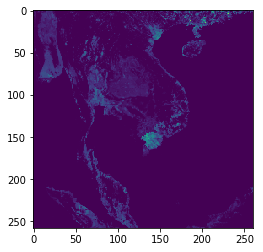

In [5]:
print("Map of the region")
plt.imshow(band[804:1062, 3287:3548])

Map of Cambodia


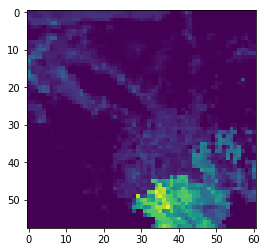

In [7]:
print("Map of Cambodia")
plt.imshow(band[904:962, 3387:3448])

# Find agricultural production per district

### Convert raster into polygons

In [3]:
print('Make polygons of each pixel')
specificBand = band#[904:962, 3387:3448]
pixelPolygons = (
    {'properties': {'raster_val': v}, 'geometry': s}
    for i, (s, v) 
    in enumerate(rasterio.features.shapes(specificBand, mask=specificBand>0, transform=src.affine))
)
pixelPolygons = list(pixelPolygons)
print("Nb polygons:", len(pixelPolygons))

pixelPolygons = gpd.GeoDataFrame.from_features(pixelPolygons)

Make polygons of each pixel
Nb polygons: 824547


In [4]:
print('Crop the figure to get only a focus on Cambodia')

def extractTopLeftCoord(polygon):
    coord = polygon.exterior.coords.xy
    return (coord[0][0], coord[1][0])

# get coords
pixelPolygons["coord"] = pixelPolygons['geometry'].apply(extractTopLeftCoord)
pixelPolygons['long'] = pixelPolygons['coord'].apply(lambda x: x[0])
pixelPolygons['lats'] = pixelPolygons['coord'].apply(lambda x: x[1])

# extract
long_lim = (102.294, 107.402)
lats_lim = (14.653, 9.779)
boolean_long = (pixelPolygons['long']>min(long_lim)-1) & (pixelPolygons['long']<max(long_lim)+1)
boolean_lats = (pixelPolygons['lats']>min(lats_lim)-1) & (pixelPolygons['lats']<max(lats_lim)+1)
pixelPolygons = pixelPolygons[boolean_long & boolean_lats]
print('Nb polygons:', pixelPolygons.shape[0])

# compute area of pixel and given an id
pixelPolygons['pixel_area'] = pixelPolygons.area
pixelPolygons['pixel_id'] = list(range(pixelPolygons.shape[0]))

Crop the figure to get only a focus on Cambodia
Nb polygons: 4177


print how it looks like


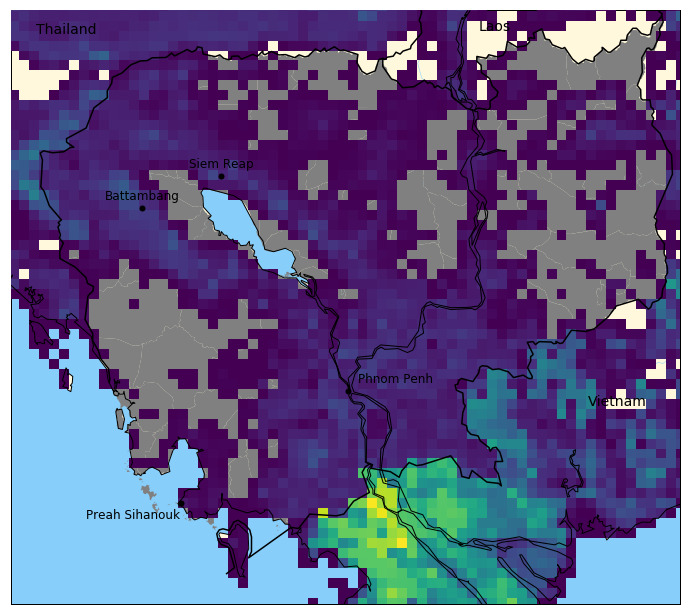

In [5]:
print('print how it looks like')
fig, ax, mm = createBasemap(figsize=12)
level2 = gpd.read_file(os.path.join(folder, "Data", "Structured", "Admin", "level2_2013.shp"))
level2.plot(ax=ax, zorder=50, color="gray")
pixelPolygons.plot(ax=ax, column='raster_val', zorder=100)

### Intersect districts and polygonzied pixels

In [76]:
#communeAg = gpd.overlay(level3, pixelPolygons, how='identity')

In [109]:
districtAg = gpd.overlay(level2.rename(columns={"area":"district_area"}), pixelPolygons, how='identity')

In [110]:
print("level2 nb polygons:", level2.shape[0])
print("pixelPolygons nb polygons:", pixelPolygons.shape[0])
print("test nb polygons:", districtAg.shape[0])

level2 nb polygons: 193
pixelPolygons nb polygons: 4177
test nb polygons: 3643


In [126]:
pixel_area = pixelPolygons.area.mode().iloc[0]
print('Pixel area is:', pixel_area)

print('')
print("We compute the area of each polygon")
districtAg['polygon_area'] = districtAg.area

print('')
print("The actuel production taking place in each little polygon is obtained by rescaling the pixel-ag-production to the area of the polygon")
districtAg['ag_production'] = districtAg['raster_val'] * districtAg['polygon_area'] / pixel_area

print('')
print('We then aggregate ag production per district')
agProdPerDistrict = districtAg.groupby('district_c')['ag_production'].sum().reset_index().rename(columns={"district_c": "district_code"})

Pixel area is: 0.006944388888998167

We compute the area of each polygon

The actuel production taking place in each little polygon is obtained by rescaling the pixel-ag-production to the area of the polygon

We then aggregate ag production per district


### Export

In [130]:
agProdPerDistrict.to_csv(os.path.join(folder, "Data", "Structured", "AgProduction", 'agProdPerDistrict.csv'), index=False)